<a href="https://colab.research.google.com/github/laxmangautam/Data-Science-with-python/blob/main/Building_Machine_Learning_Pipelines_in_PySpark_MLlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1 - Install Spark, load required libraries, set environment variables, initiate Spark, load file

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

In [100]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"
import findspark
findspark.init()
from google.colab import files
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnan, when, count, col, lit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder


In [101]:
findspark

<module 'findspark' from '/usr/local/lib/python3.7/dist-packages/findspark.py'>

In [102]:
session = SparkSession.builder.master("local[*]").getOrCreate()

In [103]:
session

In [104]:
files.upload()

Saving data.csv to data (1).csv


{'data.csv': b'Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP\nBMW,1 Series M,2011,premium unleaded (required),335,6,MANUAL,rear wheel drive,2,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135\nBMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,"Luxury,Performance",Compact,Convertible,28,19,3916,40650\nBMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350\nBMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,"Luxury,Performance",Compact,Coupe,28,18,3916,29450\nBMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,Luxury,Compact,Convertible,28,18,3916,34500\nBMW,1 Series,2012,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,"Luxury,Performance",Compact,Coupe,28,1

In [105]:
!ls

'data (1).csv'	 spark-2.4.8-bin-hadoop2.7
 data.csv	 spark-2.4.8-bin-hadoop2.7.tgz
 Pipeline	 spark-2.4.8-bin-hadoop2.7.tgz.1
 sample_data


In [106]:
data = session.read.csv('data.csv',inferSchema=True,header=True)

In [107]:
data.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Engine Fuel Type: string (nullable = true)
 |-- Engine HP: integer (nullable = true)
 |-- Engine Cylinders: integer (nullable = true)
 |-- Transmission Type: string (nullable = true)
 |-- Driven_Wheels: string (nullable = true)
 |-- Number of Doors: integer (nullable = true)
 |-- Market Category: string (nullable = true)
 |-- Vehicle Size: string (nullable = true)
 |-- Vehicle Style: string (nullable = true)
 |-- highway MPG: integer (nullable = true)
 |-- city mpg: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- MSRP: integer (nullable = true)



In [108]:
data.describe()

DataFrame[summary: string, Make: string, Model: string, Year: string, Engine Fuel Type: string, Engine HP: string, Engine Cylinders: string, Transmission Type: string, Driven_Wheels: string, Number of Doors: string, Market Category: string, Vehicle Size: string, Vehicle Style: string, highway MPG: string, city mpg: string, Popularity: string, MSRP: string]

In [109]:
data.describe().toPandas().describe()

,summary,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
count,5,3,5,5,3,5,5,3,3,5,3,3,3,5,5,5,5
unique,5,3,5,5,3,5,5,3,3,5,3,3,3,5,5,5,5
top,count,Volvo,xD,2010.384337753903,regular unleaded,55,5.628828677213059,UNKNOWN,all wheel drive,2,"Performance,Hybrid",Compact,Wagon,8.863000766979422,8.987798160299237,2,40594.737032063116
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [110]:
data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Make,11914,None,None,Acura,Volvo
Model,11914,745.5822222222222,1490.8280590623795,1 Series,xD
Year,11914,2010.384337753903,7.5797398875957995,1990,2017
Engine Fuel Type,11911,None,None,diesel,regular unleaded
Engine HP,11845,249.38607007176023,109.19187025917194,55,1001
Engine Cylinders,11884,5.628828677213059,1.78055934824622,0,16
Transmission Type,11914,None,None,AUTOMATED_MANUAL,UNKNOWN
Driven_Wheels,11914,None,None,all wheel drive,rear wheel drive
Number of Doors,11908,3.4360933825999327,0.8813153865835529,2,4


In [111]:
def replace(column, value):
  return when(column!= value, column).otherwise(lit(None))

In [112]:
data = data.withColumn("Market Category", replace(col("Market Category"),"N/A"))

In [113]:
data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Make,11914,None,None,Acura,Volvo
Model,11914,745.5822222222222,1490.8280590623795,1 Series,xD
Year,11914,2010.384337753903,7.5797398875957995,1990,2017
Engine Fuel Type,11911,None,None,diesel,regular unleaded
Engine HP,11845,249.38607007176023,109.19187025917194,55,1001
Engine Cylinders,11884,5.628828677213059,1.78055934824622,0,16
Transmission Type,11914,None,None,AUTOMATED_MANUAL,UNKNOWN
Driven_Wheels,11914,None,None,all wheel drive,rear wheel drive
Number of Doors,11908,3.4360933825999327,0.8813153865835529,2,4


In [114]:
# cound na or null value in each column
data.select([count(when(isnan(c)| col(c).isNull(), c)).alias(c)for c in data.columns]).show()

+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+
|Make|Model|Year|Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|Driven_Wheels|Number of Doors|Market Category|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity|MSRP|
+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+
|   0|    0|   0|               3|       69|              30|                0|            0|              6|           3742|           0|            0|          0|       0|         0|   0|
+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+



In [115]:
data = data.drop('Market Category')
data = data.na.drop()

In [116]:
print(data.count(), len(data.columns))

11812 15


In [117]:
data.toPandas()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335,6,MANUAL,rear wheel drive,2,Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11807,Acura,ZDX,2012,premium unleaded (required),300,6,AUTOMATIC,all wheel drive,4,Midsize,4dr Hatchback,23,16,204,46120
11808,Acura,ZDX,2012,premium unleaded (required),300,6,AUTOMATIC,all wheel drive,4,Midsize,4dr Hatchback,23,16,204,56670
11809,Acura,ZDX,2012,premium unleaded (required),300,6,AUTOMATIC,all wheel drive,4,Midsize,4dr Hatchback,23,16,204,50620
11810,Acura,ZDX,2013,premium unleaded (recommended),300,6,AUTOMATIC,all wheel drive,4,Midsize,4dr Hatchback,23,16,204,50920


Create Pipeline on Spark

In [ ]:
assembler = VectorAssembler(inputCols=['Year','Engine HP','Engine Cylinders','Number of Doors','highway MPG','city mpg','Popularity'],outputCol='Attributes')
regressor = RandomForestRegressor(featuresCol='Attributes',labelCol='MSRP')

pipeline = Pipeline(stages=[assembler, regressor])
# save the pipline and orverwiite if we have created already. 
pipeline.write().overwrite().save('Pipeline')

!ls

data.csv  sample_data		     spark-2.4.8-bin-hadoop2.7.tgz
Pipeline  spark-2.4.8-bin-hadoop2.7  spark-2.4.8-bin-hadoop2.7.tgz.1


In [ ]:
!ls

data.csv  sample_data		     spark-2.4.8-bin-hadoop2.7.tgz
Pipeline  spark-2.4.8-bin-hadoop2.7  spark-2.4.8-bin-hadoop2.7.tgz.1


In [ ]:
!ls Pipeline

metadata  stages


In [ ]:
# liad the Pipeline
pipelineModel = Pipeline.load('Pipeline')

In [ ]:
pipelineModel

Pipeline_8a4cfc87e95b

Create greed map of paramtrs that we want to  expore  RandomForest model. These paraemger could be **number of trees** , **maximum depth** or **features sub set strategy** etc.  

In [ ]:
paramGrid = ParamGridBuilder().addGrid(regressor.numTrees, [100,500]).build()

crossval = CrossValidator(estimator=pipelineModel, \
                          estimatorParamMaps=paramGrid,\
                          evaluator=RegressionEvaluator(labelCol='MSRP'), \
                          numFolds=3)
print(paramGrid)
print(crossval)

[{Param(parent='RandomForestRegressor_666d58ff11af', name='numTrees', doc='Number of trees to train (>= 1).'): 100}, {Param(parent='RandomForestRegressor_666d58ff11af', name='numTrees', doc='Number of trees to train (>= 1).'): 500}]
CrossValidator_d49070696a9c


In [ ]:
train_data, test_data = data.randomSplit([0.8,0.2],seed=123)


In [ ]:
cvModel = crossval.fit(train_data)

In [ ]:
bestModel = cvModel.bestModel
for x in range(len(bestModel.stages)):
  print(bestModel.stages[x])

VectorAssembler_ee77aa80a806
RandomForestRegressionModel (uid=RandomForestRegressor_666d58ff11af) with 100 trees


In [ ]:
pred = cvModel.transform(test_data)

In [ ]:
pred.select('MSRP','Prediction').show()

+-----+------------------+
| MSRP|        Prediction|
+-----+------------------+
|29980|31764.117970242933|
|28030|31870.722960912088|
|30030|31870.722960912088|
|32700|35930.356110027155|
|29350| 24178.82641246634|
|31890| 27655.11511731385|
|34980| 27655.11511731385|
| 2799|5424.7379696657745|
| 2827| 5191.627003503582|
| 3381| 5743.709731104614|
|24450|26541.834171921913|
|21050| 23552.14994120279|
| 2000|5647.8316390093605|
| 2181| 7295.211014475785|
| 2144| 6016.433419644005|
| 2265| 7344.082138945086|
|56780|  39972.5854348629|
|49440|  39972.5854348629|
|50640|  39972.5854348629|
|52640|  39972.5854348629|
+-----+------------------+
only showing top 20 rows



In [ ]:
eval = RegressionEvaluator(labelCol='MSRP')
rmse = eval.evaluate(pred)

In [ ]:
mse= eval.evaluate(pred, {eval.metricName:'mse'})
mae= eval.evaluate(pred, {eval.metricName:'mae'})
r2= eval.evaluate(pred, {eval.metricName:'r2'})

In [ ]:
print(mse, mae,r2)

276598597.82339257 8466.641614695855 0.8785311510977989


In [118]:
dataPandadf = data.toPandas()
dataPandadf

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335,6,MANUAL,rear wheel drive,2,Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11807,Acura,ZDX,2012,premium unleaded (required),300,6,AUTOMATIC,all wheel drive,4,Midsize,4dr Hatchback,23,16,204,46120
11808,Acura,ZDX,2012,premium unleaded (required),300,6,AUTOMATIC,all wheel drive,4,Midsize,4dr Hatchback,23,16,204,56670
11809,Acura,ZDX,2012,premium unleaded (required),300,6,AUTOMATIC,all wheel drive,4,Midsize,4dr Hatchback,23,16,204,50620
11810,Acura,ZDX,2013,premium unleaded (recommended),300,6,AUTOMATIC,all wheel drive,4,Midsize,4dr Hatchback,23,16,204,50920


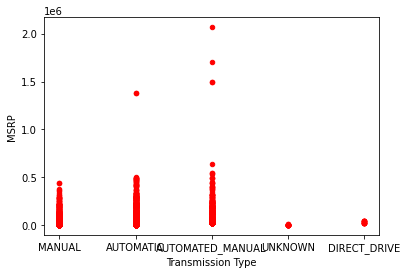

In [122]:
dataPandadf.plot.scatter(x='Transmission Type',y='MSRP', c='Red')

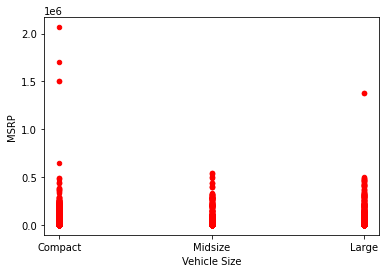

In [123]:
dataPandadf.plot.scatter(x='Vehicle Size',y='MSRP', c='Red')

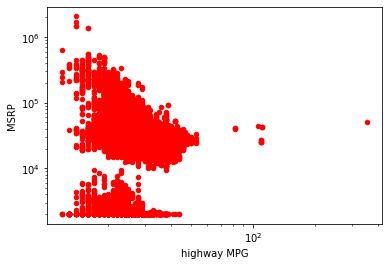

In [136]:
dataPandadf.plot.scatter(logy=True,logx=True, x='highway MPG',y='MSRP', c='Red')

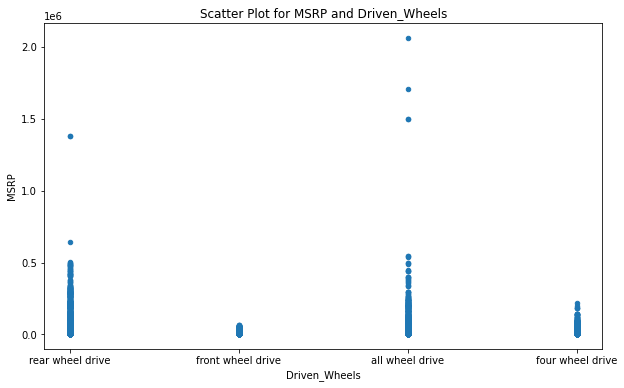

In [126]:
dataPandadf.plot(kind='scatter',
        x='Driven_Wheels', 
        y='MSRP',
        title = 'Scatter Plot for MSRP and Driven_Wheels',
        figsize=(10,6));

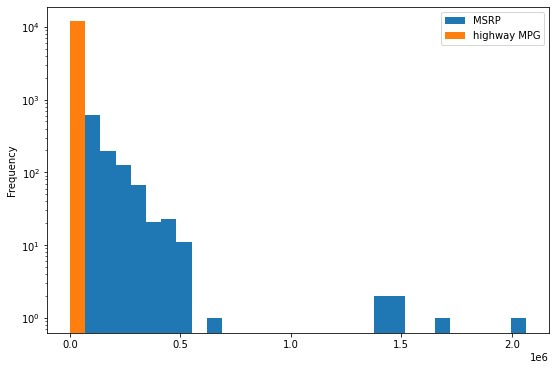

In [134]:
import math
dataPandadf[['MSRP','highway MPG']].plot(logy=True, kind='hist',figsize=(9,6), bins=30);